In [1]:
# For compatibility across multiple platforms
import os
import numpy as np
import pandas as pd
from scipy import spatial
import gc
import time
import seaborn as sns
import random
random.seed(42)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Load files using DictReader in Python
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import cluster
from sklearn import preprocessing
from sklearn.model_selection import KFold
import sklearn

In [2]:
train_filepath = "pubg-finish-placement-prediction/train_V2_clean.csv"

#trainset_file = open(train_filepath,'rU')
trainset = pd.read_csv(train_filepath,index_col=0)


/usr/local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
print(len(trainset))

4446965


## Remove Illegal Match

# Normalization and feature engineering

Add a feature for the number of players joined

In [4]:
trainset['playersJoined'] = trainset.groupby('matchId')['matchId'].transform('count')
trainset['killsNorm'] = trainset['kills']*((100-trainset['playersJoined'])/100 + 1)
trainset['damageDealtNorm'] = trainset['damageDealt']*((100-trainset['playersJoined'])/100 + 1)
trainset['maxPlaceNorm'] = trainset['maxPlace']*((100-trainset['playersJoined'])/100 + 1)
trainset['matchDurationNorm'] = trainset['matchDuration']*((100-trainset['playersJoined'])/100 + 1)

# Visualize Most Important Features

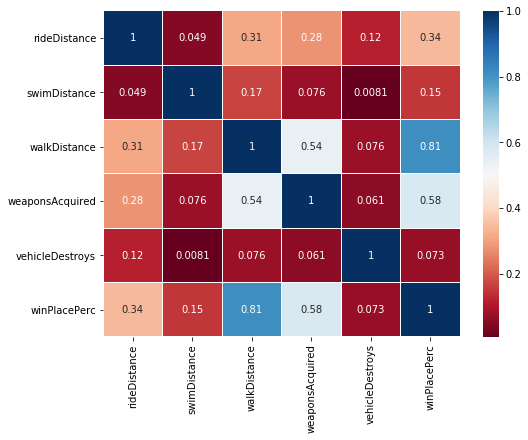

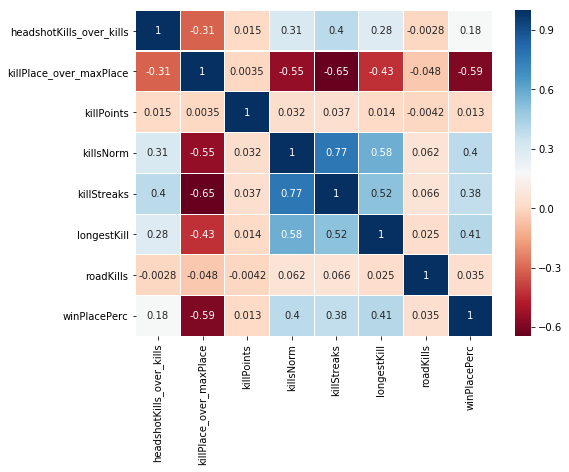

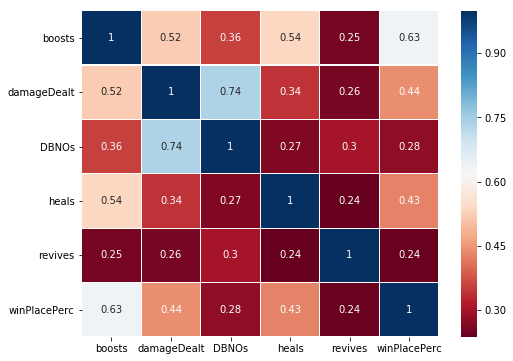

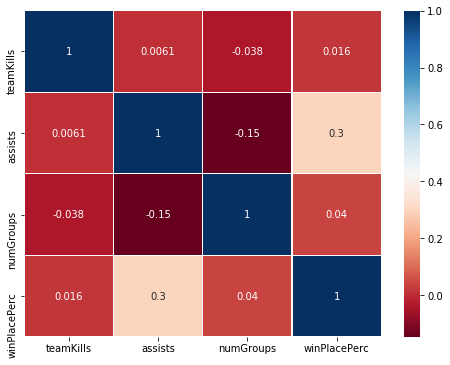

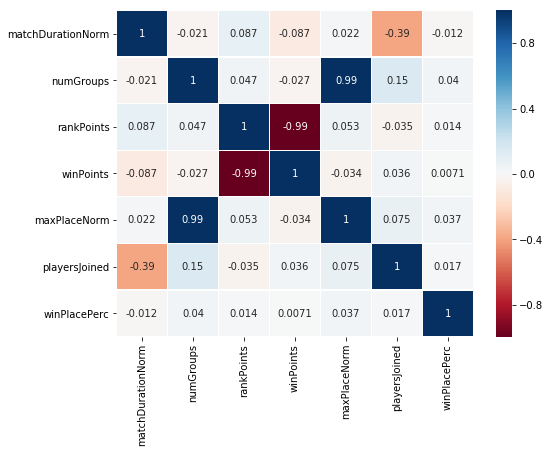

In [5]:
# cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']
# cols_to_fit = [col for col in trainset.columns if col not in cols_to_drop]
# corr = trainset[cols_to_fit].corr()

# plt.figure(figsize=(9,7))
# sns.heatmap(
#     corr,
#     xticklabels=corr.columns.values,
#     yticklabels=corr.columns.values,
#     linecolor='white',
#     linewidths=0.1,
#     cmap="RdBu"
# )
# plt.show()

agg = trainset.groupby(['groupId']).size().to_frame('players_in_team')
trainset = trainset.merge(agg, how='left', on=['groupId'])
trainset['headshotKills_over_kills'] = trainset['headshotKills'] / trainset['kills']
trainset['headshotKills_over_kills'].fillna(0, inplace=True)
trainset['killPlace_over_maxPlace'] = trainset['killPlace'] / trainset['maxPlace']
trainset['killPlace_over_maxPlace'].fillna(0, inplace=True)
trainset['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
corr_travel = trainset[['rideDistance','swimDistance','walkDistance','weaponsAcquired','vehicleDestroys','winPlacePerc']].corr()
corr_kills = trainset[['headshotKills_over_kills','killPlace_over_maxPlace','killPoints','killsNorm','killStreaks','longestKill','roadKills','winPlacePerc']].corr()
corr_health = trainset[['boosts','damageDealt','DBNOs','heals','revives','winPlacePerc']].corr()
corr_teamstats = trainset[['teamKills','assists','numGroups','winPlacePerc']].corr()
corr_matchstats = trainset[['matchDurationNorm','numGroups','rankPoints','winPoints','maxPlaceNorm','playersJoined','winPlacePerc']].corr()
#corr = trainset[['killPlace', 'walkDistance', 'players_in_team', 'headshotKills_over_kills', 'killPlace_over_maxPlace', 'winPlacePerc']].corr()
corr_tuple = (corr_travel,corr_kills,corr_health,corr_teamstats,corr_matchstats)
for corr in corr_tuple:
    plt.figure(figsize=(8,6))
    sns.heatmap(
        corr,
        xticklabels=corr.columns.values,
        yticklabels=corr.columns.values,
        annot=True,
        linecolor='white',
        linewidths=0.1,
        cmap="RdBu"
    )
    plt.show()

# Train on XGBoost

In [6]:
train_columns = list(trainset.columns[:-1])
x = trainset.drop(["matchType","winPlacePerc"],axis=1)
y = trainset["winPlacePerc"]



x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [7]:
x_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,weaponsAcquired,winPoints,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,players_in_team,headshotKills_over_kills,killPlace_over_maxPlace
410924,54453833424516617,9985988022161988,21380477812988733,0,1,23.22,0,0,2,79,...,4,1538,98,0.00,23.6844,49.98,1420.86,3,0.0,1.612245
4112256,41354219741260506,20212045961435148,13691352515206426,0,0,0.00,0,0,0,74,...,1,0,93,0.00,0.0000,99.51,1500.14,1,0.0,0.795699
3076460,33383523291928895,8199574711929678,29719689807901141,0,0,100.00,1,1,0,41,...,2,0,96,1.04,104.0000,50.96,1814.80,2,1.0,0.836735
926200,38472004182000689,19699503196321072,15873927234808751,1,0,191.90,1,0,5,24,...,2,0,96,2.08,199.5760,50.96,2060.24,2,0.0,0.489796
481625,18509418360732673,56472084487646608,13695822967665637,0,0,0.00,0,0,0,88,...,1,1536,98,0.00,0.0000,30.60,1389.24,8,0.0,2.933333


In [8]:
print(trainset.columns)

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playersJoined',
       'killsNorm', 'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'players_in_team', 'headshotKills_over_kills',
       'killPlace_over_maxPlace'],
      dtype='object')


In [9]:
trainset_dmatrix = xgb.DMatrix(x_train.values,label=y_train.values, feature_names=x_train.columns)
valset_dmatrix = xgb.DMatrix(x_val.values,label=y_val.values, feature_names=x_train.columns)

In [10]:
params = {
    "max_depth" : 10,
    "eval_metric" : ["mae"],
}

In [11]:
clf = xgb.train(params, trainset_dmatrix, evals=[(trainset_dmatrix, "train"),(valset_dmatrix, 'val')], num_boost_round = 10)



[18:55:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1894 extra nodes, 0 pruned nodes, max_depth=10
[0]	train-mae:0.195851	val-mae:0.195794
[18:55:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1920 extra nodes, 0 pruned nodes, max_depth=10
[1]	train-mae:0.146373	val-mae:0.14631
[18:56:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1958 extra nodes, 0 pruned nodes, max_depth=10
[2]	train-mae:0.113319	val-mae:0.113297
[18:56:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1958 extra nodes, 0 pruned nodes, max_depth=10
[3]	train-mae:0.092404	val-mae:0.092421
[18:57:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1948 extra nodes, 0 pruned nodes, max_depth=10
[4]	train-mae:0.07877	val-mae:0.078865
[18:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1960 extra nodes, 0 pruned nodes, max_depth=10
[5]	train-mae:0.070317	val-mae:0.070475
[18:58:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1958

In [12]:
# predictions = clf.predict(valset_dmatrix)

# Plot Shap Values for entire dataset

In [19]:
shap_data = x_train.iloc[0:10000,:]
print(shap_data.columns)

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 'numGroups',
       'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance',
       'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired',
       'winPoints', 'playersJoined', 'killsNorm', 'damageDealtNorm',
       'maxPlaceNorm', 'matchDurationNorm', 'players_in_team',
       'headshotKills_over_kills', 'killPlace_over_maxPlace'],
      dtype='object')


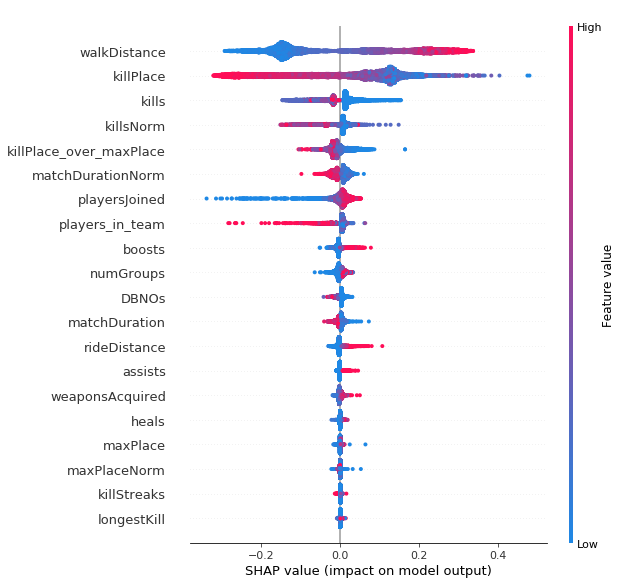

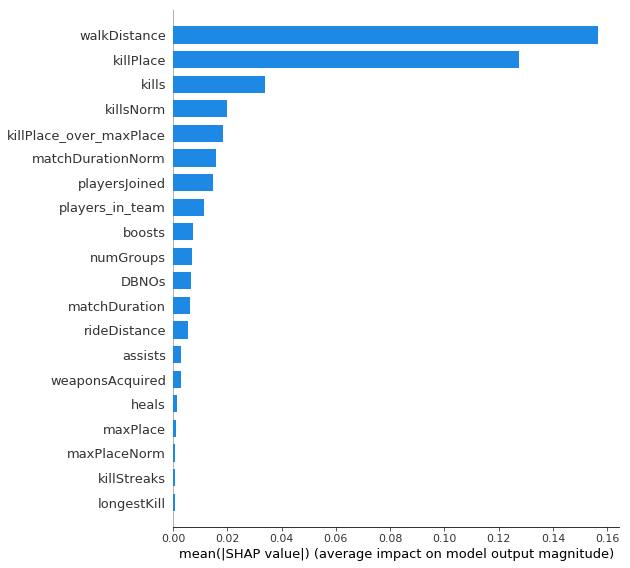

In [20]:
import shap
# load JS visualization code to notebook
shap.initjs()
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(shap_data)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], shap_data.iloc[0,:])

# summarize the effects of all the features
shap.summary_plot(shap_values, shap_data)

shap.summary_plot(shap_values, shap_data, plot_type="bar")



# Individual feature SHAP value plots

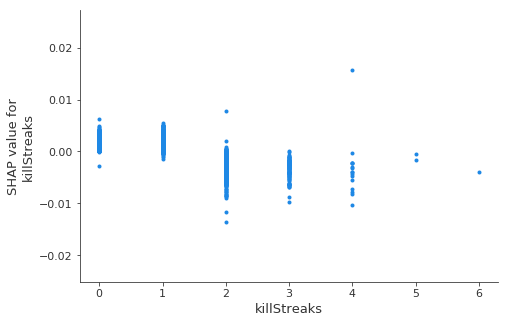

In [24]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("killStreaks", shap_values, shap_data, interaction_index=None)